# Выявление определяющих успешность игры закономерностей

Цель - выявить определяющие успешность игры закономерности на основе  доступных исторических данных о продажах игр, оценок пользователей и экспертов, жанр и платформ. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## ПОДГОТОВКА И ПРЕДОБРАБОТКА ДАННЫХ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import mannwhitneyu

In [2]:
!pip install pandas -U
!pip install matplotlib -U
!pip install seaborn -U

  Using cached pandas-1.4.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'installed-files.txt'
Consider using the `--user` option or check the permissions.

  Using cached matplotlib-3.5.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'LICENSE'
Consider using the `--user` option or check the permissions.

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'LICENSE

### Используемые в исследовании переменные:

<br>**df** - исходный датасет;
<br>**platform_pivot** - свобная таблица по общему количеству всех проданных игр по годам для каждой платформы;
<br>**most_popular_by_sales_platform** - платформы с самыми высокими продажами за весь пеиод наблюдения;
<br>**df_pop_filt_ex_2016** -  выборка из топа 7 платформ с самыми высокими продажами
<br>**df_pop_filt_ex_2016_pivot** - предыдушая выборка, но сгруппированныя по общему количеству всех проданных игр по годам для каждой платформы;
<br>**df_actual** - данные только за актуальный период 2011-2015;
<br>**df_actual_query** - данные за актуальный период с исключением платформ "PS2", "X360", "PS3"
<br>**df_actual_pivot** - данные за актуальный период, сгруппированные по годам;
<br>**df_actual_by_total_sales_query** - данные за актуальный период, дополнительно очищенные от выбросов;
<br>**most_popular_genres** - сгруппированные по жанрам исходные данные;
<br>**genres_count** - данные за актуальный период, сгруппированные по жанрам и их количеству;
<br>**most_popular_genres** - данные о жанрах за актуальный период, сгруппированные по количеству продаж;
<br>**xone_rating** - данные только по платформе XOne (для теста);
<br>**pc_rating** - данные только по ПК (для стат. теста)
<br>**action_rating** - выборка по жанру Action (для проверки гипотезы);
<br>**sports_rating**- выборка по жанру Sports (для проверки гипотезы).

In [3]:
df = pd.read_csv('/datasets/games.csv')

In [4]:
#создадим функцию для описания датафреймов
def info_data(data_frame):
    print('Информация о колонках\n')
    print( data_frame.info() )
    
    print('\nИнформация о релизе видеоигр')
    display( data_frame.head() )
    
    print('\nКоличество пропусков в колонках')
    display(data_frame.duplicated().sum())
    
    return

In [5]:
info_data(df)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None

Информация о релизе видеоигр


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN



Количество пропусков в колонках


0

In [6]:
#сначала приведем все названия столбцов к нижнему регистру:
df.columns = df.columns.str.lower()

In [7]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
#отдельно представим информацию о количестве и доле пропусков в каждом столбце:
numbers_of_nulls = pd.DataFrame(columns = ['names'], data = df.columns)
numbers_of_nulls['nulls'] = df.isnull().sum().values
numbers_of_nulls['nulls_percent']= 100*df.isnull().sum().values/df.shape[0]      
numbers_of_nulls

,names,nulls,nulls_percent
0,name,2,0.011965
1,platform,0,0.000000
2,year_of_release,269,1.609333
3,genre,2,0.011965
4,na_sales,0,0.000000
5,eu_sales,0,0.000000
6,jp_sales,0,0.000000
7,other_sales,0,0.000000
8,critic_score,8578,51.319174
9,user_score,6701,40.089740


Итак, мы видим небольшое некритичное количество пропусков в столбцах:
- 'name', которые определенно не заменить;
- 'year_of_release', которых некритичное количество, и можно удалить;
- 'genre' - также в количестве yе критичном для удаления;

Столбцы 'critic_score', 'user_score', 'rating' имеют большое количество пропусков, не подлежащих замене на какое-либо валидное значение, они останутся без изменений.

In [9]:
df = df.dropna(subset = ['name', 'year_of_release', 'genre'])

Столбец 'year_of_release' для наглядности и удобства приведем к целочисленному типу:

In [10]:
df['year_of_release']= df['year_of_release'].astype('Int64')

Колонка 'user_score' странным образом имеет строковый тип, выведем её уникальные значения, чтобы посмотреть внимательнее:

In [11]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

значение 'tbd' звменим на Nan  и приведем столбец к типу float

In [12]:
df['user_score']= df['user_score'].replace('tbd', np.nan).astype('float64')

### Расшифровка рейтинга игр

Теперь поближе рассмотрим уникальные значения столбца 'rating':

In [13]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Источник: https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board
<br>E («Everyone») — «Для всех»
<br>M («Mature») — «Для взрослых»
<br>T («Teen») — «Подросткам»
<br>E10+ («Everyone 10 and older») — «Для всех от 10 лет и старше»
<br>K-A ("Kids to Adults") - первоначальное название категории E 
<br>AO («Adults Only 18+») — «Только для взрослых» 
<br>EC («Early childhood») — «Для детей младшего возраста» 
<br>RP («Rating Pending») — «Рейтинг ожидается» 

Значения E и K-A подразумевают одну категорию игр, и для удобства заменим значения K-A на E:

In [14]:
df['rating']= df['rating'].replace('K-A', 'E')


Заменим пропуски в столбце рейтинга игр на значение "Нет рейтинга". Насколько мне удалось выяснить, рейтинг ESBR был принят только в 1994 и обязателен только для США и Канады.


In [15]:
df['rating']=df['rating'].fillna('Нет рейтинга')

###  Добавление синтетического столбца с общими продажами:

In [16]:
df['total_sales']= df['na_sales']+ df['eu_sales']+df['jp_sales']+df['other_sales']

In [17]:
info_data(df)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB
None

Информация о релизе видеоигр


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,Нет рейтинга,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,Нет рейтинга,31.38



Количество пропусков в колонках


0

### Общие сведения об исследуемых платформах

Посмотрим внимательнее на платформы, выпускающие игры, представленные в датасете (для общего понимания):

In [18]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

- **Wii** -  игровая приставка 7-го поколения, 6-я домашняя консоль фирмы Nintendo и наследница Nintendo GameCube. Дата выхода 19 ноября 2006. Поддержка прекращена	20 октября 2013;
- **NES** - (Nintendo Entertainment System) Впервые консоль появилась на японском рынке в 1983 году под названием Famicom, а затем, переименованная в NES, вышла в Европе и США в 1985 году. Новинка оказалась исключительно удачной и сумела завоевать практически весь американский и японский рынок. Поддержка прекращена	1995 (США) и  25 сентября 2003 (Япония);
- **GB** - (Game Boy) линейка портативных игровых устройств, разработанная и производившаяся Nintendo.Первый Game Boy был выпущен ещё в 1989 году как продолжение к известным карманным играм Nintendo Game & Watch. Это была первая популярная портативная игровая система, и многие компании пытались повторить успех Game Boy, но никому сделать этого так и не удалось.
- **DS** - (Nintendo DS) следующее поколение карманных игровых консолей компании Nintendo после Game Boy Advance SP. Консоль была выпущена в 2004 году в Канаде, США и Японии.Поддержка прекращена 31 августа 2013;
- **X360** - Xbox 360 — вторая по счёту игровая приставка компании Microsoft, которая последовала за Xbox. Конкурентами Xbox 360 среди игровых платформ седьмого поколения являлись PlayStation 3 от Sony Computer Entertainment и Wii от Nintendo[9]. Некоторые из основных функций Xbox 360 представлены сервисом Xbox Live, позволяющим играть через Интернет, а также загружать разнообразный контент — видеоигры, демоверсии, трейлеры, музыку, ТВ-шоу и т. п. Дата выхода 22 ноября 2005. Поддержка прекращена 20 апреля 2016;
- **PS3** - (PlayStation 3)  — игровая приставка седьмого поколения, третья в семействе игровых систем PlayStation (не считая PlayStation Portable). С помощью PS3 можно играть, смотреть фильмы, слушать музыку, отправлять электронную почту и просматривать веб-страницы. С самого момента выпуска приставкой поддерживается большинство игр для консолей 7-ого поколения, PlayStation и PlayStation 2. Главными конкурентами консоли являются Xbox 360 от Microsoft и Wii от Nintendo. 	Дата выхода 11 ноября 2006;
- **PS2** - (PlayStation 2) вторая игровая приставка, выпущенная компанией Sony, наследница PlayStation и предшественница PlayStation 3. Шестое поколение. О начале разработки было объявлено в марте 1999 г., продажа консоли в Японии началась 4 марта 2000 г. Игровая приставка стала наиболее быстро продаваемой и самой популярной игровой консолью в истории. На третий квартал 2011 года в мире продано почти 155 миллионов экземпляров PS2. Поддержка прекращена 4 января 2013;
- **SNES** - (Super Nintendo Entertainment System) - консоль приобрела популярность во многих странах, став самой продаваемой 16-битной приставкой, несмотря на упорную конкуренцию в Северной Америке со стороны Sega. SNES осталась популярна в эпоху 32-битных систем среди фанатов, коллекционеров и энтузиастов, работающих с эмуляцией (которые создают самодельные образы ПЗУ).Дата выхода 21 ноября 1990. Поддержка прекращена	сентябрь 2003;
- **GBA** - Game Boy Advance — 32-разрядная портативная игровая система компании Nintendo. Является «наследницей» Game Boy Color. Дата выхода 21 марта 2001 года. В 2004 году наступил спад продаж этой консоли, потому что Nintendo выпустила новую игровую консоль — Nintendo DS, и в конечном счёте поддержка прекратилась в 2006 году, однако поддержка в США и Европе продолжалась до 2008 года;
- **PS4** - PlayStation 4 — игровая приставка восьмого поколения, выпускаемая японской компанией Sony. PlayStation 4 входит в семейство игровых приставок PlayStation и была выпущена на смену PlayStation 3 — предыдущей домашней игровой консоли той же компании;
- **3DS** - Nintendo 3DS — портативная игровая система производства Nintendo, способная создавать трёхмерный эффект изображения за счёт автостереоскопии, то есть без использования специальных очков. Консоль поступила в продажу во всех регионах до конца финансового года Nintendo, завершившегося в конце марта 2011 г. Игровая система присутствует на рынке одновременно с линейкой игровых систем Nintendo DS. 
- **N64** - Nintendo 64 , также Ultra 64 и N64 — 64-разрядная игровая приставка. Разрабатывалась японской компанией Nintendo совместно с Silicon Graphics. Была выпущена в 1996 году (23 июня в Японии и 29 сентября в США) и стала ответом на приставки конкурентов Sony PlayStation и Sega Saturn. Поддержка прекращена 30 апреля 2002 г;
- **PS** - Оригинальная PlayStation или PlayStation 1 была выпущена 3 декабря 1994 года в Японии, в США приставка появилась 9 сентября 1995 года. Она стала частью пятого поколения игровых систем. Впоследствии консоль вышла в специальной чёрной окраске под названием Net Yaroze. В 1999 году Sony выпустила PocketStation — периферийное устройство для оригинальной PlayStation. 7 июля 2000 года была выпущена PS one, которая являлась уменьшенной версией PlayStation. Из-за своей доступности PS One превосходил по продажам все остальные консоли на рынке в течение некоторого времени. К марту 2007 года года продажи PS one в общей сложности составили более 28 миллионов устройств;
- **XB** - Xbox — домашняя игровая приставка, разработанная и выпущенная американской компанией Microsoft, первая в серии игровых приставок Xbox. Выход Xbox в США и Канаде состоялся в ноябре 2001 года, в остальном мире — в 2002 году. Это устройство представляло собой первую — и успешную — попытку Microsoft выйти на рынок домашних игровых приставок, где на протяжении многих лет доминировали японские производители, и занять достаточную его долю. Как приставка шестого поколения, Xbox напрямую конкурировала с PlayStation 2 от Sony, GameCube от Nintendo и Dreamcast от Sega. Поддержка прекращена 29 ноября 2005;
- **PC** - Персональный компьютер в качестве платформы для видеоигр. Игру Spacewar!, разработанную для PDP-1 в 1961, принято называть самой первой компьютерной игрой.  Кризис индустрии компьютерных игр 1983 года. Вследствие наводнения рынка множеством игровых приставок и низкокачественными играми, присущего консолям предыдущего поколения, агрессивной ценовой и рекламной политики их производителей, возник большой спрос на домашние компьютеры, что вызвало рост интереса к рынку PC-игр. Так продажи Commodore 64 резко увеличились, а такие разработчики, как Electronic Arts, заинтересовались в платформе. На несколько лет индустрия компьютерных игр стала убыточной, из-за чего на рынке явно обозначился застой. Лишь только некоторое время спустя Nintendo удалось прорваться на рынок США со своей «системой развлечений» (NES — Nintendo Entertainment System). В Европе кризис прошёл гораздо позже;
- **2600** - Atari VCS, позже названная Atari 2600, появилась к Рождеству 1977 года и стала доминирующей игровой приставкой конца 1970-х — начала 1980-х. Она стала первой успешной приставкой с играми на картриджах. В 1980-х в США слово «Atari» воспринималось как синоним «Atari 2600». Модель обычно поставлялась с двумя джойстиками либо двумя paddle-контроллерами и одной игрой — сначала это была Combat, а затем Pac-Man. Консоль Atari 2600 Jr. продавали в Азии до 1990 года, а в США и Европе вплоть до 1991 года. Последней лицензионной игрой стала вышедшая в 1990 году KLAX. За всё время жизненного цикла консоли было продано свыше 30 миллионов единиц, а библиотека игр насчитывает более 900 наименований. Прекращение официальной поддержки Atari 2600 со стороны Atari Corp. состоялось 1 января 1992 года, что делает её самой долгоживущей консолью в истории видеоигр — 14 лет, 2 месяца;
- **PSP** - PlayStation Portable, также известная как PSP FAT; PSP Slim (Slim and Lite); PSP Slim and Lite (Bright); PSP Go; PSP Street — портативная игровая консоль производства Sony Computer Entertainment. PlayStation Portable — четвертый продукт компании Sony в линейке PlayStation. Анонс PSP состоялся на выставке E3 2003[5], а первая консоль была продемонстрирована публике 11 мая 2004 года. Поддержка прекращена15 сентября 2014 года;
- **XOne** - Xbox One — третья по счёту игровая приставка от компании Microsoft, являющаяся преемницей Xbox 360. Конкурентами Xbox One среди игровых платформ восьмого поколения являются PlayStation 4 от Sony Computer Entertainment, Wii U и Nintendo Switch от Nintendo.Анонс состоялся 21 мая 2013 года;
- **WiiU** - (кодовое название Project Café) — название игровой консоли Nintendo, которая является преемником Wii. Система была представлена на пресс-конференции Nintendo 7 июня 2011 года на выставке E3 2011, выпущена в 2012 году. Производство прекращено в 2017 году в связи с выходом Nintendo Switch;
- **GC** - (Nintendo GameCube)  официально названная GCN на Западе и NGC в Япониичетвёртая домашняя игровая консоль от Nintendo, относится к шестому поколению игровых систем. Преемник Nintendo 64 и предшественник Wii. Дата выхода 14 сентября 2001. Поддержка прекращена	22 февраля 2007;
- **GEN** - Sega Mega Drive , в Северной Америке известна как Sega Genesis — игровая приставка четвёртого поколения, разработанная и выпускавшаяся компанией Sega. Приставка была выпущена в 1988 году в Японии как Mega Drive, в 1989 году в США как Genesis. Поддержка прекращена в 1999;
- **DC** - (Dreamcast) — домашняя игровая приставка, выпущенная компанией Sega 27 ноября 1998 года в Японии. Она была первой в шестом поколении игровых систем, и предшествовала PlayStation 2 от Sony, GameCube от Nintendo и Xbox от Microsoft. Dreamcast стала последней домашней игровой системой Sega, завершив восемнадцатилетнюю историю компании на рынке консолей. Поддержка прекращена	31 марта 2001;
- **PSV** - (PlayStation Vita, PS Vita) портативная консоль от Sony Computer Entertainment, преемник PlayStation Portable. Выпущена в Японии 17 декабря 2011 года;
- **SAT** - (Sega Saturn)  — домашняя игровая приставка, разработанная компанией Sega и выпущенная 22 ноября 1994 года в Японии. Поддержка прекращена	4 декабря 2000;
- **SCD** - (Sega Mega-CD)  — дополнение к игровой приставке Sega Mega Drive от компании Sega, выпущенное в рамках четвёртого поколения игровых систем. В Северной Америке система носила название Sega CD. Она была выпущена в Японии 12 декабря 1991 года, в Северной Америке — 15 октября 1992 года и в Европе — 2 апреля 1993 года. Устройство улучшало возможности Mega Drive и добавляло возможность проигрывать игры, записанные на компакт-диске, слушать аудиодиски и запускать диски формата CD+G. Поддержка прекращена	в 1996;
- **WS** - (WonderSwan) — портативная игровая консоль компании Bandai, выпущенная в 1999 году только в Японии;
- **NG** - Сервис «N-Gage» был представлен компанией Nokia в августе 2007 года, и предназначен для запуска игр на Symbian-смартфонах. С его помощью можно было бесплатно опробовать игры, разработанные на платформе N-Gage на любом из совместимых устройств от Nokia, а любую понравившуюся игру — приобрести со своего устройства или персонального компьютера и загрузить.Сервис N-Gage стал доступен во всех странах мира с 8 апреля 2008 года. Летом 2009 года N-Gage 2.0 признана закрытой, умершей платформой;
- **TG16** - (PC Engine, он же TurboGrafx-16) — 8-16 разрядная игровая приставка, выпущенная NEC в Японии 30 октября 1987 года, в Северной Америке в конце августа 1989 года под именем TurboGrafx-16. Поддержка прекращена	в 1994;
- **3DO** - (3DO Interactive Multiplayer или просто 3DO) — игровая приставка, выпускавшаяся в 1993—1996 гг. компаниями Panasonic, Sanyo, Creative и Goldstar. Консоль производилась в соответствии с набором спецификаций, предложенных The 3DO Company. Несмотря на активную рекламу, сопровождавшую запуск системы, и использование передовых технологий, высокая цена системы и перенасыщение рынка игровых систем привели к быстрому завершению её жизненного цикла.Поддержка прекращена в 1996;
- **GG** - (Sega Game Gear)  — 8-битная портативная игровая система четвёртого поколения, выпущенная компанией Sega. Система поступила в продажу 6 октября 1990 года в Японии. Поддержка прекращена	в 1997;
- **PCFX** - PC-FX — 32-разрядная игровая консоль, разработанная компанией NEC. Преемник предыдущей консоли от этой компании, PC Engine (известной в США под названием TurboGrafx 16). Выпущена в Японии 23 декабря 1994 года. PC-FX использовала для хранения игр только CD-диски, в отличие от PCE (TG16), игры для которой хранились на специальных картриджах HuCards (а также на CD, при наличии внешнего, или встроенного в некоторых моделях, CD-привода). 

Источник: https://ru.wikipedia.org

### Общий вывод по итогам предобработки

Из возможных причин наличия в датасете такого количества пропусков можно указать огромный временной промежуток, охватывающий данные.  Предполагаю, что значения многих столбцов заполнялись вручную. Также есть вероятность того, что итоговый датасет стал итогом множества сджойненных таблиц, и метод объединения был не совсем корректным, отсюда и множество NaNов

##  ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

###  Сколько игр выходило в разные годы:

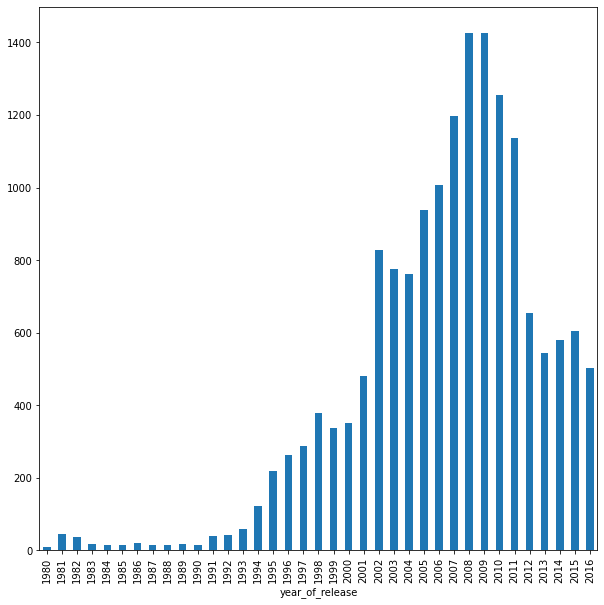

In [19]:
(df.groupby('year_of_release')['name'].agg('count')
 .plot(kind = 'bar', figsize=(10, 10)))
plt.show()

Барчарт демонстрирует, что наибольшее количество игр было выпущено2008-2009 годах. Резкий рост игровая индустрия демонстрирует с 2002 года, но с 2012 пошел ещё более стремительный спад.

###  Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


Создадим таблицу, которая содержит данные по общему количеству всех проданных игр по годам для каждой платформы:

In [21]:
platform_pivot= df.pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['total_sales'], aggfunc = 'sum')
platform_pivot

total_sales                                                  \
platform               2600   3DO    3DS    DC      DS     GB    GBA     GC   
year_of_release                                                               
1980                  11.38   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1981                  35.68   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1982                  28.88   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1983                   5.84   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1984                   0.27   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1985                   0.45   NaN    NaN   NaN    0.02    NaN    NaN    NaN   
1986                   0.67   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1987                   1.94   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1988                   0.74   NaN    NaN   NaN     NaN   1.43    NaN    NaN   
1989                   0.63   NaN    NaN   NaN     NaN  64.97    NaN    NaN   
1990                    NaN   NaN    NaN   NaN     NaN   4.89    NaN    NaN   
1991                    NaN   NaN    NaN   NaN     NaN   5.57    NaN    NaN   
1992                    NaN   NaN    NaN   NaN     NaN  25.49    NaN    NaN   
1993                    NaN   NaN    NaN   NaN     NaN    NaN    NaN    NaN   
1994                    NaN  0.02    NaN   NaN     NaN  12.18    NaN    NaN   
1995                    NaN  0.08    NaN   NaN     NaN   3.60    NaN    NaN   
1996                    NaN   NaN    NaN   NaN     NaN  36.03    NaN    NaN   
1997                    NaN   NaN    NaN   NaN     NaN   6.37    NaN    NaN   
1998                    NaN   NaN    NaN  3.38     NaN  26.90    NaN    NaN   
1999                    NaN   NaN    NaN  5.16     NaN  38.00    NaN    NaN   
2000                    NaN   NaN    NaN  5.99     NaN  19.76   0.07    NaN   
2001                    NaN   NaN    NaN  1.07     NaN   9.24  61.53  26.34   
2002                    NaN   NaN    NaN  0.29     NaN    NaN  74.16  51.81   
2003                    NaN   NaN    NaN   NaN     NaN    NaN  56.67  50.61   
2004                    NaN   NaN    NaN   NaN   17.27    NaN  77.91  28.82   
2005                    NaN   NaN    NaN   NaN  130.14    NaN  33.86  27.62   
2006                    NaN   NaN    NaN   NaN  119.81    NaN   5.28  11.26   
2007                    NaN   NaN    NaN  0.02  146.94    NaN   3.40   0.27   
2008                    NaN   NaN    NaN  0.04  145.31    NaN    NaN    NaN   
2009                    NaN   NaN    NaN   NaN  119.54    NaN    NaN    NaN   
2010                    NaN   NaN    NaN   NaN   85.02    NaN    NaN    NaN   
2011                    NaN   NaN  63.20   NaN   26.18    NaN    NaN    NaN   
2012                    NaN   NaN  51.36   NaN   11.01    NaN    NaN    NaN   
2013                    NaN   NaN  56.57   NaN    1.54    NaN    NaN    NaN   
2014                    NaN   NaN  43.76   NaN     NaN    NaN    NaN    NaN   
2015                    NaN   NaN  27.78   NaN     NaN    NaN    NaN    NaN   
2016                    NaN   NaN  15.14   NaN     NaN    NaN    NaN    NaN   

                              ...                                          \
platform           GEN    GG  ...    SAT   SCD   SNES  TG16    WS     Wii   
year_of_release               ...                                           
1980               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1981               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1982               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1983               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1984               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1985               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1986               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1987               NaN   NaN  ...    NaN   NaN    NaN   NaN   NaN     NaN   
1988    

Построим график, который отображает динамику продаж по годам для каждой из представленных платформ.

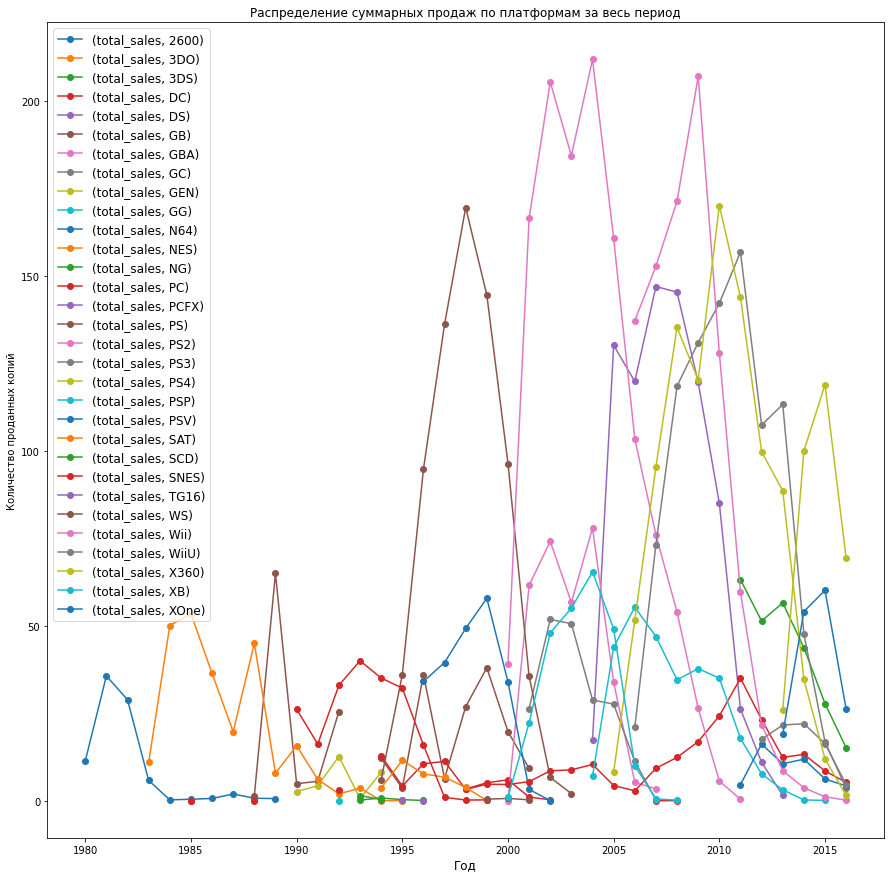

In [22]:
platform_pivot.plot(style='o-', title='Распределение суммарных продаж по платформам за весь период', figsize=(15, 15))
plt.legend(loc='upper left', fontsize='large')
plt.xlabel('Год', fontsize='large')
plt.ylabel('Количество проданных копий');

График демонстрирует 7 игровых платформ, чьи релизы серьезно превосходят остальные. Взглянем на них поподробнее.

In [23]:
most_popular_by_sales_platform = df.groupby('platform').agg({'total_sales':'sum'}).reset_index()
most_popular_by_sales_platform.sort_values(by='total_sales', ascending=False).head(7)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14


In [24]:
df_pop_filt_ex_2016 = df.query('platform == ["PS2", "X360", "PS3", "Wii", "DS", "PS", "PS4"]')

In [25]:
df_pop_filt_ex_2016_pivot = df_pop_filt_ex_2016.pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['total_sales'], aggfunc = 'sum')

In [26]:
#удалим из распределения данные за 2016 год, так как он ещё не завершён, а на продажи особенно влияет предновогодний период.
df_pop_filt_ex_2016_pivot = df_pop_filt_ex_2016_pivot.drop(index=[2016])

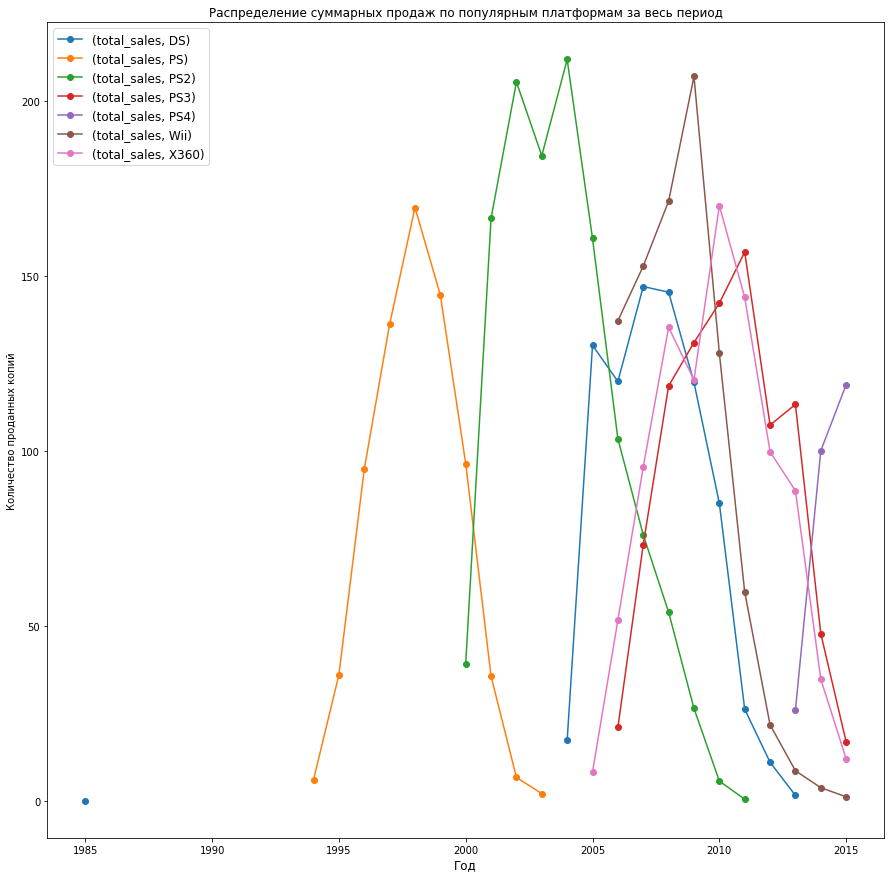

In [27]:
df_pop_filt_ex_2016_pivot.plot(style='o-', title='Распределение суммарных продаж по популярным платформам за весь период', figsize=(15, 15))
plt.legend(loc='upper left', fontsize='large')
plt.xlabel('Год', fontsize='large')
plt.ylabel('Количество проданных копий');

"Колокол" жизненного цикла плафтформ и на основании общего графика, и графика только с топ-7 консолей, демонстрирует, что средний период примерно в 5 лет. Исключение сотавляет ПК. 

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.


Актуальным периодом назначим промежуток 2013-2015 


In [28]:
df_actual = df.query('year_of_release >= 2013 and year_of_release < 2016')

In [29]:
df_actual_pivot= df_actual.pivot_table(index = ['year_of_release'], columns = ['platform'], values = ['total_sales'], aggfunc = 'sum')
df_actual_pivot

total_sales                                                  \
platform                3DS    DS     PC     PS3     PS4   PSP    PSV   Wii   
year_of_release                                                               
2013                  56.57  1.54  12.38  113.25   25.99  3.14  10.59  8.59   
2014                  43.76   NaN  13.28   47.76  100.00  0.24  11.90  3.75   
2015                  27.78   NaN   8.52   16.82  118.90  0.12   6.25  1.14   

                                      
platform          WiiU   X360   XOne  
year_of_release                       
2013             21.65  88.58  18.96  
2014             22.03  34.74  54.07  
2015             16.35  11.96  60.14

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

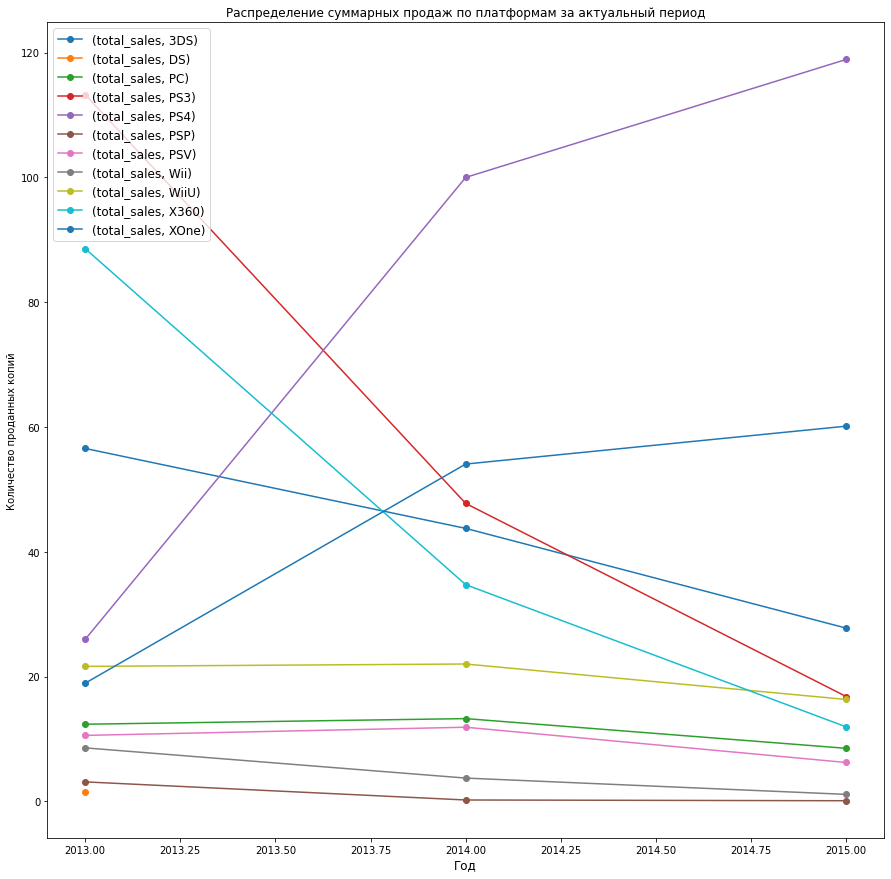

In [30]:
df_actual_pivot.plot(style='o-', title='Распределение суммарных продаж по платформам за актуальный период', figsize=(15, 15))
plt.legend(loc='upper left', fontsize='large')
plt.xlabel('Год', fontsize='large')
plt.ylabel('Количество проданных копий');

Перспективными по данным актуального периода можно назвать только две консоли - PS4 и XOne - которые демонстрируют рост.
Wii, WiiU, PSP, PSV, PC<3DS демонстрируют некоторое постоянство.
Безнадежный спад - PS3, X360(что естесственно, когда сменяется поколение платформ в одной серии).


### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Ящик будем строить по небезнадёжным платформам актуального периода. Для этого сначала актуализируем переменную.

In [31]:
df_actual_query = df_actual.query('platform != ["PS2", "X360", "PS3"]')

In [32]:
info_data(df_actual_query)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 31 to 16707
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1251 non-null   object 
 1   platform         1251 non-null   object 
 2   year_of_release  1251 non-null   Int64  
 3   genre            1251 non-null   object 
 4   na_sales         1251 non-null   float64
 5   eu_sales         1251 non-null   float64
 6   jp_sales         1251 non-null   float64
 7   other_sales      1251 non-null   float64
 8   critic_score     557 non-null    float64
 9   user_score       617 non-null    float64
 10  rating           1251 non-null   object 
 11  total_sales      1251 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 128.3+ KB
None

Информация о релизе видеоигр


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Нет рейтинга,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Нет рейтинга,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,Нет рейтинга,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58



Количество пропусков в колонках


0

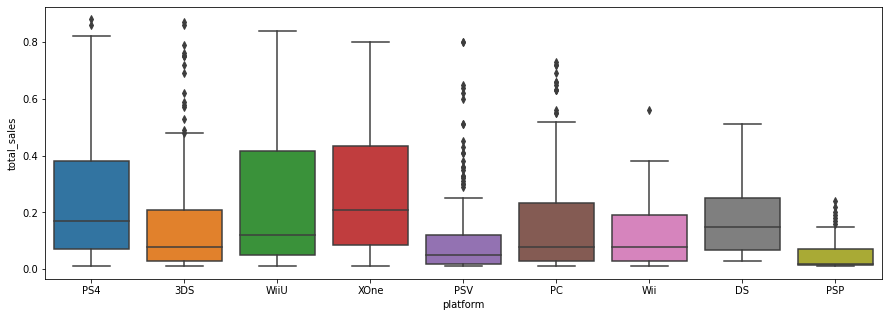

In [33]:
#визуализации по боксплотам очень препятствуют выбросы, ящики получаются очень маленькими, не помогает параметр showfliers=False. 
#уберем из поля зрения хотя бы те значения, которые выходят за q3 + 2*iqr
df_actual_query['total_sales'].describe()
q1 =  0.040000
q3 =  0.320000
iqr = q3 - q1
df_actual_by_total_sales = df_actual_query[~df_actual_query['total_sales'].isna()]
df_actual_by_total_sales_query = df_actual_by_total_sales.query('total_sales <= @q3 + 2 * @iqr')
fig, ax = plt.subplots(figsize = (15,5))
sns.boxplot(x='platform', y='total_sales', data=df_actual_by_total_sales_query, ax=ax);

Медиана проданных копий в актуальный период выше всего у XOne, хотя платформа существует даже не с начала периода.
Второе место также занимает недавно предстваленная PS4, что подтверждает большие её высокие перспективы в развитии.
Wii и WiiU демонстрируют стабильный высокий интерес покупателей.
Чуть ниже идут PC и 3DS, но ПК не имеет таких жищненных циклов, как консоли. Продажи игр для ПК, скорее всего, будут занимать свой невысокий сегмент всегда.



### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Зависимость продаж от оценки критиков и юзеров для XOne


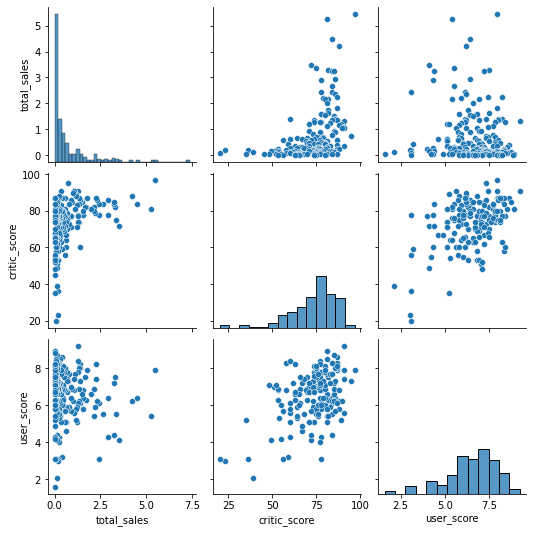

In [34]:
#построим  диаграммe рассеивания для одной популярной платформы (XOne)
#которая отразит зависимость между продажами и отзывами (пользователей и критиков)
sns.pairplot(df[df.platform == "XOne"][['total_sales', 'critic_score', 'user_score']])
print('Зависимость продаж от оценки критиков и юзеров для XOne')
plt.show()

Высокая оценка критиков влияет на продажи больше, чем оценка пользователей: у игр с высокой оценкой критиков продажи лучше. А вот оценка пользователей почти не влияет на продажи. 

In [35]:
print("Таблица корреляции между продажами оценками критиков и юзеров для XOne")
df[df.platform == "XOne"][['total_sales', 'critic_score', 'user_score']].corr()

Таблица корреляции между продажами оценками критиков и юзеров для XOne


,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


Коэффициент корреляции между продажами и оценкой критиков  0.4 говорит о явной прямой пропорциональности между этими параметрами;
Коэффициент корреляции между продажами и оценкой юзеров  -0.068925, что говорит почти о полном отсутствии взаимосвязи.
Предполагаю, что к 8 пколению приставок у пользователей игровых платформ уже сформировался определенный вкус, и они купят версию игры для новой консоли, несмотря на то, что она не оправдала ожиданий других игроков.

Так как XOne - платформа, которая ещё не завершила свой жизненный цикл, рассмотрим зависимость аналогичны параметров для X360

Зависимость продаж от оценки критиков и юзеров для X360


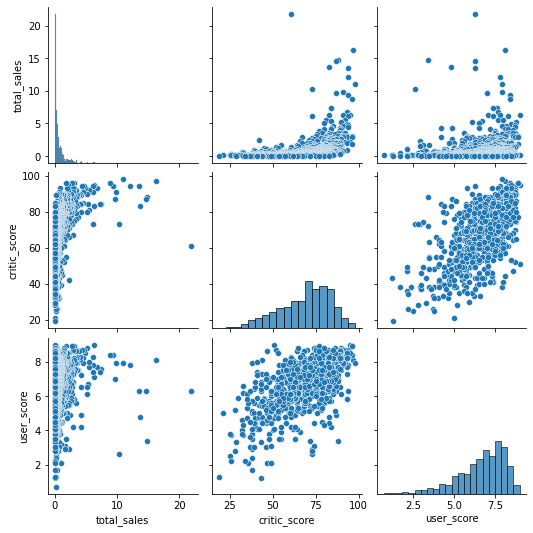

In [36]:
sns.pairplot(df[df.platform == "X360"][['total_sales', 'critic_score', 'user_score']])
print('Зависимость продаж от оценки критиков и юзеров для X360')
plt.show()

In [37]:
print("Таблица корреляции между продажами оценками критиков и юзеров для X360")
df[df.platform == "X360"][['total_sales', 'critic_score', 'user_score']].corr()

Таблица корреляции между продажами оценками критиков и юзеров для X360


,total_sales,critic_score,user_score
total_sales,1.000000,0.392866,0.114187
critic_score,0.392866,1.000000,0.625020
user_score,0.114187,0.625020,1.000000


Визуализация данных платформы, прошедшей жизненный цикл подсказывает, что зависимость между выбором пользователей и продажами немного возрастет.
И ещё заметно, что в большинстве случаев критики и пользователи солидарны в своих оценках.
Коррелиция между оценками критиков и продажами останется практически неизменной.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

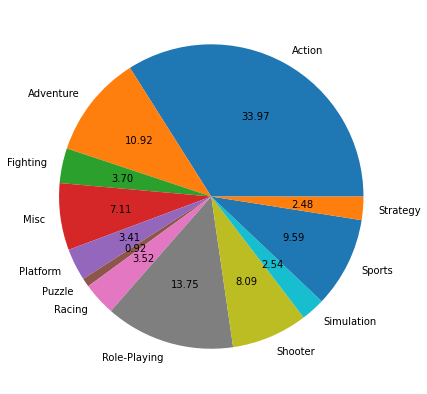

In [38]:
genres_count=df_actual.groupby("genre")['genre'].count()
genres = genres_count.index
plt.figure(figsize=(20,7))
plt.pie(x=genres_count, labels=genres, autopct="%.2f")
plt.show()

In [39]:
most_popular_genres = df_actual.groupby('genre').agg({'total_sales':'median'}).reset_index()
most_popular_genres.sort_values(by='total_sales', ascending=False).head(5)

,genre,total_sales
8,Shooter,0.585
10,Sports,0.365
4,Platform,0.310
6,Racing,0.220
3,Misc,0.170


Итак, общемировой тренд (топ-5)  в жанрах игр: шутеры, спортивные симуляторы, платформеры, гонки и игры из категории Skill-and-action

In [40]:
most_popular_genres.sort_values(by='total_sales').head(5)

,genre,total_sales
1,Adventure,0.030
5,Puzzle,0.065
11,Strategy,0.080
0,Action,0.130
2,Fighting,0.130


Анти-топ-5 по медианным продажам: приключенческие, паззлы, стратегии, экшн, имитации боев.

### Общий вывод по итогам исследовательского анализа

<br> Жизненный цикл консоли составляет примерно 5 лет;
<br> На момент исследования 2 консоли находятся на стадии роста, причем одна из них - XOne - уже демонстрирует рекордные продажи, хотя она даже не дошла до пика "колокола" жизненного цикла; 
<br> Продажи в большей степени зависят от профессиональной оценки, чем от пользовательской;
<br> 5 жанров пользуются наибольшей популярностью по всему миру: шутеры, спортивные симуляторы, платформеры, гонки и игры из категории Skill-and-action

## ПОРТРЕТ ПОЛЬЗОВАТЕЛЯ В КАЖДОМ РЕГИОНЕ

Зададим функцию, которая будет строить барчарты по сгруппированным данным и покажет визуально топ-5 платформ, жанров и лидирующих рейтингов в регионе за весь исследуемый период по числу проданных копий игр:

In [41]:
def buildbarchart(row, title):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    for pivot, ax in zip(list(['platform','genre','rating']),axes.flatten()[:3]):
        pivot_data = df_actual.pivot_table(index=pivot, values=row, aggfunc='sum'
                  ).sort_values(by=row, ascending=False).reset_index().rename_axis(None, axis=1).head(5)
        print(pivot_data)
        print('\n\n') 
        sns.barplot(data=pivot_data, x=pivot, y=row, ax=ax)
        fig.suptitle(title, fontsize=20)
        

plt.show()

### Портрет пользователя в Северной Америке

  platform  na_sales
0      PS4     87.25
1     X360     80.97
2     XOne     78.85
3      PS3     62.83
4      3DS     34.06



          genre  na_sales
0        Action    116.76
1       Shooter     93.50
2        Sports     57.73
3  Role-Playing     40.51
4          Misc     26.73



         rating  na_sales
0             M    149.54
1  Нет рейтинга     80.89
2             E     71.08
3          E10+     50.43
4             T     40.84





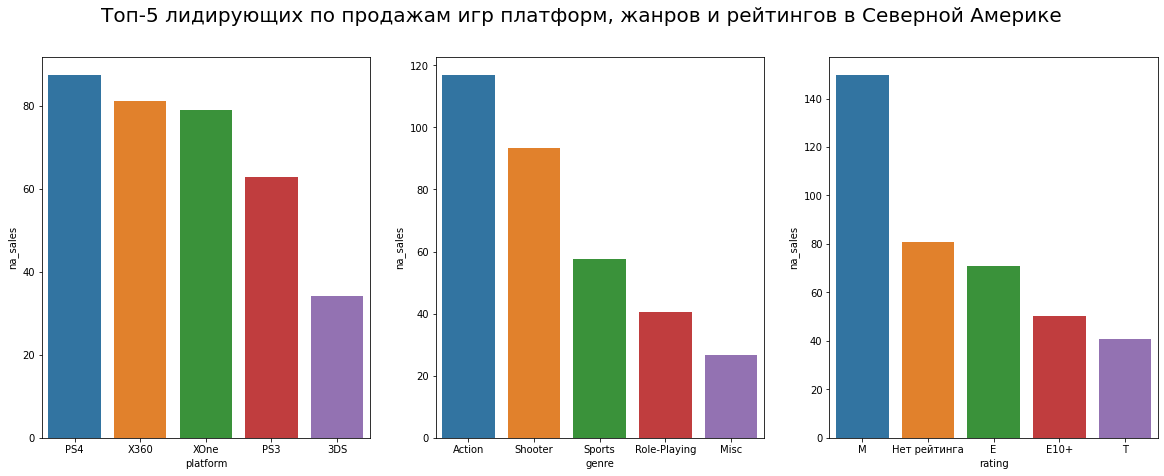

In [42]:
buildbarchart('na_sales','Топ-5 лидирующих по продажам игр платформ, жанров и рейтингов в Северной Америке')

- В Северной Америке за актуальный период наблюдений абсолютным лидером продаж стала консоль PS4. Немного отстает X360.
- Из жанров лидирует экшн. Гонкам американцы предпочитают РПГ.
- И рейтинг M, то есть игры для взрослых, который превалируют над остальными(см. п. 1.2.). 

### Портрет пользователя в Европе

  platform  eu_sales
0      PS4    109.31
1      PS3     66.55
2     XOne     41.96
3     X360     41.81
4      3DS     28.63



          genre  eu_sales
0        Action    107.45
1       Shooter     71.96
2        Sports     48.51
3  Role-Playing     32.69
4          Misc     19.38



         rating  eu_sales
0             M    128.78
1  Нет рейтинга     71.44
2             E     69.75
3          E10+     38.88
4             T     32.16





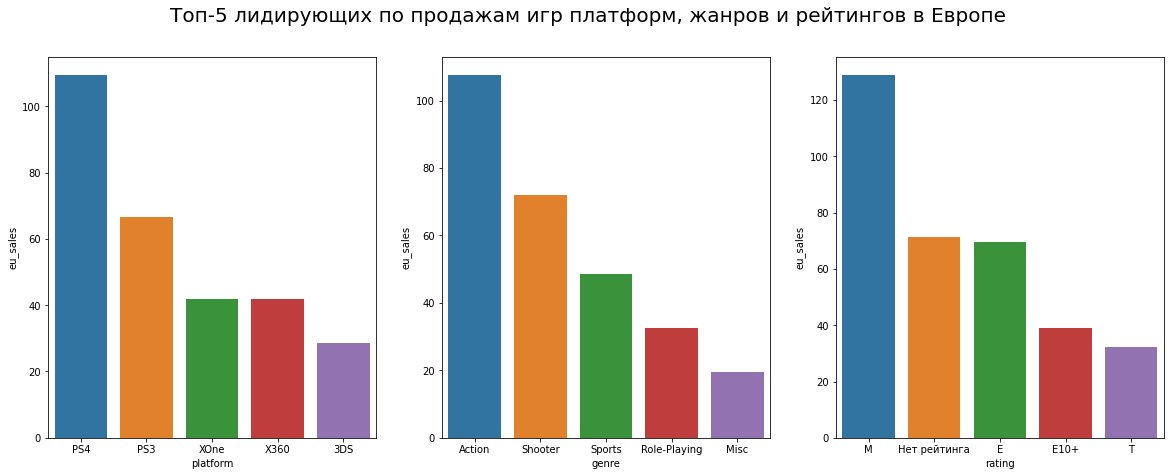

In [43]:
buildbarchart('eu_sales','Топ-5 лидирующих по продажам игр платформ, жанров и рейтингов в Европе')

- В Европе лидируют консоли марки PlayStation.
- Популярные жанры аналогичны североамериканским показателям, только 1 место, жанр экшн, лидирует с большим отрывом.
- Рейтинг рййтингов также аналогичен североамериканскому.

### Портрет пользователя в Японии

  platform  jp_sales
0      3DS     59.78
1      PS3     22.05
2      PSV     15.03
3      PS4     10.22
4     WiiU     10.21



          genre  jp_sales
0  Role-Playing     44.43
1        Action     33.42
2          Misc      8.16
3      Fighting      6.90
4       Shooter      5.55



         rating  jp_sales
0  Нет рейтинга     70.73
1             T     18.32
2             E     14.07
3             M     12.91
4          E10+      5.44





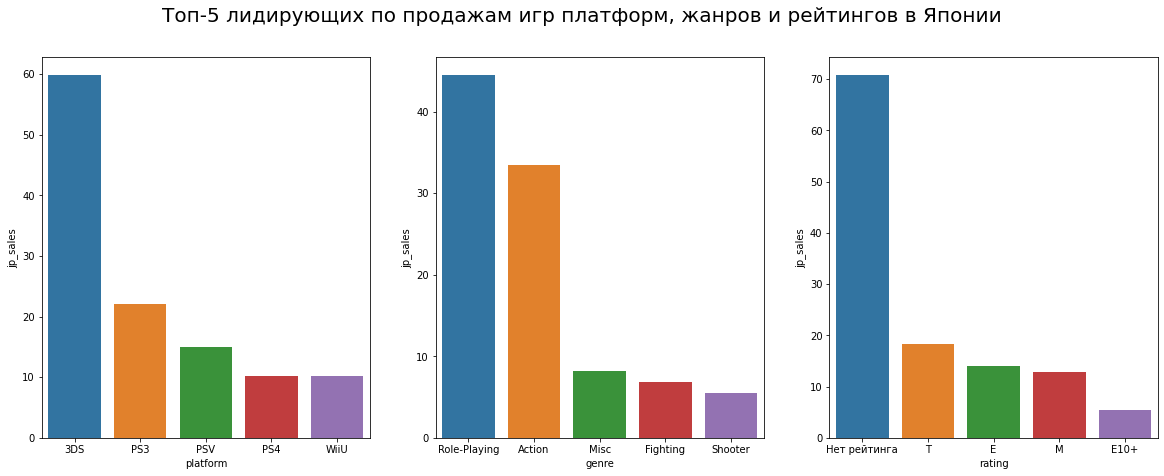

In [44]:
buildbarchart('jp_sales','Топ-5 лидирующих по продажам игр платформ, жанров и рейтингов в Японии')

- А вот в Японии платформа 3DS была популярна на рынке больше всех остальных с огромным отрывом.  сегмент Playstation представлен на рынке 3мя консолями. XBox даже нет в рейтинге. 
- Значительно превалирует над остальными в топе жанр РПГ. Японская картина популярных жанров отлична от предыдущих показателей. Среди популярных жанров представлены симуляторы боев, которые входят в мировой антирейтинг.
- Абсолютно лидируют по продажам игры, которым не присвоен рейтинг. Для Японии это необязательное условие.

### Общий вывод за актуальный период

**По платформам:** На американском рынке больший сегмент занимают консоли Xbox, на втором месте PS, небольшую часть - 3DS. На европейском - PlayStation, Xbox меньше, последнее место за 3DS. Японский же рынок устроен наоборот - лидер - 3DS.
**По жанрам** ACtion, sports и шутеры любят и в Америке, и в ЕвропеБ в то время как японцы отдают абсолютное предпочтение РПГ. 
**По категориям рейтинга** Игры для взрослых (М) -абсолютные лидеры в Европе и Америке. В Японии превалируют игры без рейтинга, так как в этой стране присвоение ESBR не обязательно. На всех рынках большое место занимает категория для подростков (T) и для всех возрастов(E).

## ПРОВЕРКА ГИПОТЕЗ

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Чтобы определиться с видом статистического теста, посмотрим на распределение данных в пользовательских рейтингах обеих платформ. 

In [45]:
xone_rating = df_actual.query('platform == "X360"')
xone_rating['user_score'].agg(['mean','var','std'])

mean    6.086765
var     2.307083
std     1.518908
Name: user_score, dtype: float64

In [46]:
pc_rating = df_actual.query('platform == "PC"')
pc_rating['user_score'].agg(['mean','var','std'])

mean    6.258182
var     3.066676
std     1.751193
Name: user_score, dtype: float64

По параметрам (среднему, дисперсии и стандарстному отклонению) данные в выборках распределены примерно одинаково только по среднему, но убедимся в этом на графике:

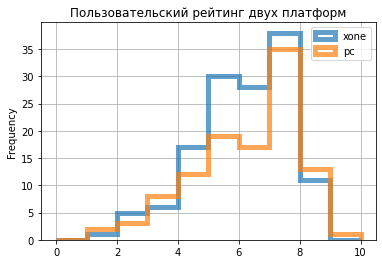

In [47]:
ax = xone_rating.plot(
    kind='hist',
    y='user_score',
    histtype='step',
    range=(0, 10),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='xone',
)
pc_rating.plot(
    kind='hist',
    y='user_score',
    histtype='step',
    range=(0, 10),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='pc',
    ax=ax,
    grid=True,
    legend=True,
)
plt.title('Пользовательский рейтинг двух платформ')
plt.show()

В данных присутствует большое к-во выбросов, но если ограничиться областью стандартных оценок, то даже в этом случае распределение нельзя назвать нормальным. Для двух независимых выборок с отсутствием номального распределения выберем критерий Манна-Уитни. 

**Сформулируем нулевую и альтернативную гипотезы:**
<br>H0 - средние пользовательские рейтинги(за актуальный период) ХOne и PC равны;
<br>H1 - средние пользовательские рейтинги(за актуальный период) ХOne и PC не равны.

In [48]:
stat, p = mannwhitneyu(xone_rating['user_score'], pc_rating['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


Statistics=nan, p=nan
Не получилось отвергнуть нулевую гипотезу


**Статистический тест не опроверг гипотезу о равенстве средних пользовательских рейтингов  XOne и PC.**

### Средние пользовательские рейтинги жанров Action  и Sports

Создадим выборки по двум заданным жанрам и посмотрим на их параметры распределения и график (все по аналогии с п. 4.1.)

In [49]:
action_rating = df_actual.query('genre == "Action"')
action_rating ['user_score'].agg(['mean','var','std'])

mean    6.893092
var     1.650612
std     1.284762
Name: user_score, dtype: float64

In [50]:
sports_rating = df_actual.query('genre == "Sports"')
sports_rating ['user_score'].agg(['mean','var','std'])

mean    5.179675
var     2.901633
std     1.703418
Name: user_score, dtype: float64

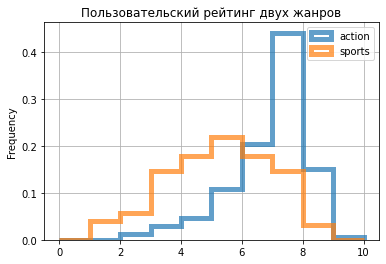

In [51]:
ax = action_rating.plot(
    kind='hist',
    y='user_score',
    histtype='step',
    range=(0, 10),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='action',
    density=True
)
sports_rating .plot(
    kind='hist',
    y='user_score',
    histtype='step',
    range=(0, 10),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='sports',
    ax=ax,
    grid=True,
    legend=True,
    density=True
)
plt.title('Пользовательский рейтинг двух жанров')
plt.show()

Распределение также нельзя назвать нормальным. Схожесть параметров дает нам основание предполагать, что средние значения приблизительно одинаковы, но проведем тест. 

**Сформулируем нулевую и альтернативную гипотезы:**
<br>H0 - средние пользовательские рейтинги(за актуальный период) жанров  Action и Sports равны;
<br>H1 - средние пользовательские рейтинги(за актуальный период) жанров  Action и Sports не равны.

In [52]:

stat, p = mannwhitneyu(action_rating['user_score'], sports_rating['user_score'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Statistics=nan, p=nan
Не получилось отвергнуть нулевую гипотезу



    
Результат статистического теста:
- не отвергнута гипотеза о равенстве средних пользовательских рейтингов  XOne и PC;
- отвергнута гипотеза о том, что средние пользовательские рейтинги двух жанров Action и Sports равны


## ОБЩИЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ ПО ЗАКУПКАМ

Российскому Магазину "Стримчик" рекомендуется закупать ассортимент игр, исходя из комбинации трендов, с большей ориентацией на североамериканские и европейские тренды: 
- для новых и идущих на подьем консолей PS4 и XOne, но с учётом, что многие пользователи ещё не поменяли консоли, и X360 и PS3 некоторое время будут востребованы на рынке. 
- Не стоит забывать о ПК - достаточно стабильный сегмент. 
- По жанрам: всегда востребован ACtion, Sports, Shooter. Большим спросом пользуются игры для взрослых, а также с рейтингом "Для всех" и "Для подростков".
- Выбор лучше всего основывать на профессиональном рейтинге критиков.